# One Sample Tutorial - Human Fibroblasts

Here is a walkthrough for using VeloCycle for manfiold-constrained RNA velocity estimation of the cell cycle.

This tutorial estimates the cell cycle speed for a single dataset of human fibroblasts from Capolupo et al. 2022. This is a case where there is only one sample. For a more advanced tutorial on using two samples for velocity estimation, please see the second tutorial.

## Load VeloCycle

In [1]:
import velocycle as vc
from velocycle import *

In [2]:
# generic & ml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pyro
import copy
import scipy
import pycircstat
import pickle
from scipy.stats import pearsonr
from scipy.linalg import lstsq
import statsmodels.api as sm

# scRNA-seq
import scanpy as sc
import anndata

### Optional: set the default device to the GPU

If you do not have a GPU on your device, please set USE_GPU = False to run the rest of this notebook. For large datasets, runtimes will be slower.

In [3]:
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    print("Will use GPU")
    device = torch.device("cuda:0")
else:
    print("Will use CPU")
    device = torch.device("cpu")

Will use GPU


## Load dataset and perform gene filtering

In [4]:
data = sc.read_h5ad("capolupo_fibroblasts_cycling.h5ad")
data.obs["batch"] = "fibroblasts" # give the sample an informative name

In [5]:
sc.pp.filter_genes(data, min_cells=int((data.n_obs)*0.10))

In [6]:
data = data[:, (data.layers["unspliced"].toarray().mean(0) > 0.1)].copy()
data = data[:, data.layers["spliced"].toarray().mean(0) > 0.3].copy()

In [7]:
# Create design matrix for dataset with a single sample/batch
batch_design_matrix = preprocessing.make_design_matrix(data, ids="batch")

In [8]:
# Rough approximation of the cell cycle phase using categorical approaches 
sc.tl.score_genes_cell_cycle(data, s_genes=utils.S_genes_human, g2m_genes=utils.G2M_genes_human)

In [9]:
# Create size-normalized data layers, which are only used to obtain a PCA phase prior
# VeloCycle operates on the raw counts and has a built-in count factor term
preprocessing.normalize_total(data)

In [10]:
# Get biologically-relevant gene set to use for velocity estimation
# Three sizes are offered in VeloCycle, taken from the literature: 
# Large (Gene Ontology), Medium (DeepCycle), and Small (Seurat)
full_keep_genes = utils.get_cycling_gene_set(size="Large", species="Human")

## Initialize manifold-learning

Initialize a "cycle" and "phase" object, which will store the manifold geometry and coordinates

Geometry: fourier series coefficients describing each gene

Coordinates: phase position for each cell on the cell cycle circle

In [11]:
cycle_prior = cycle.Cycle.trivial_prior(gene_names=full_keep_genes, harmonics=1)

In [12]:
# Keep only genes from biologically-relevant gene set that are present in the current dataset
cycle_prior, data_to_fit = preprocessing.filter_shared_genes(cycle_prior, data, filter_type="intersection")

In [13]:
# Update the priors for gene harmonics
# to gene-specific means and stds
S = data_to_fit.layers['spliced'].toarray()
S_means = S.mean(axis=0) #sum over cells
nu0 = np.log(S_means)

# Mean prior
S_frac_means=np.vstack((nu0, 0*nu0, 0*nu0))
cycle_prior.set_means(S_frac_means)

# Standard deviation prior
nu0std = np.std(np.log(S+1), axis=0)/2
S_frac_stds=np.vstack((nu0std, 0.5*nu0std, 0.5*nu0std))
cycle_prior.set_stds(S_frac_stds)

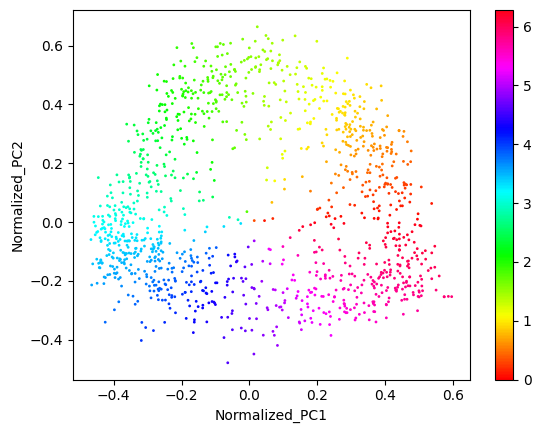

In [14]:
# Obtain a PCA prior for individual cell phases
# The prior for cell cycle coordinates are taken from the first two components of the PCA
# This is the only step of the model that relies on log transformed counts - but still no smoothing is performed
data_to_fit.layers["S_sz_log"] = np.log(data_to_fit.layers["S_sz"]+1)
phase_prior = phases.Phases.from_pca_heuristic(data_to_fit, 
                                               genes_to_use=utils.get_cycling_gene_set(size="Small", species="Human"), 
                                               layer='S_sz_log',
                                               concentration=5.0, plot=True, small_count=1)

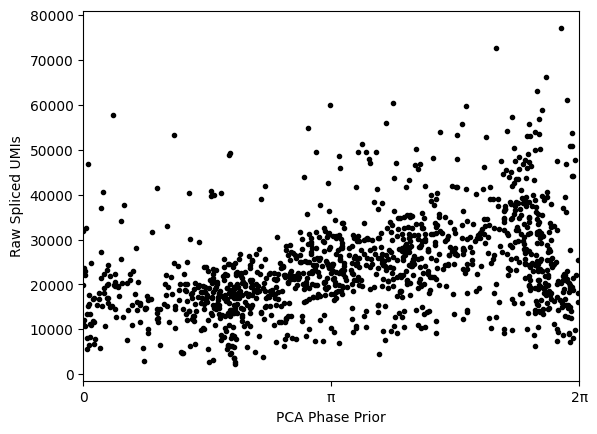

In [15]:
# Shift the phase prior to have maximum correlation with the total raw UMI counts
(shift, maxcor, allcor) = phase_prior.max_corr(data_to_fit.obs.n_scounts)
phase_prior.rotate(angle=-shift)
plt.plot(phase_prior.phis, data_to_fit.obs.n_scounts, '.', c='black')
plt.xlim(0, np.pi*2)
plt.xticks([0, np.pi, 2*np.pi],["0", "π", "2π"])
plt.xlabel("PCA Phase Prior")
plt.ylabel("Raw Spliced UMIs")
plt.show()

## Run manifold-learning

In [16]:
pyro.clear_param_store()

In [17]:
# Call a preprocessing function to metaparameters to provide to Pyro
metapar = preprocessing.preprocess_for_phase_estimation(anndata=data_to_fit, 
                                          cycle_obj=cycle_prior, 
                                          phase_obj=phase_prior, 
                                          design_mtx=batch_design_matrix,
                                          n_harmonics=1,
                                          device = device,
                                          with_delta_nu=False)

In [18]:
# Define a pyro object for phase inference
phase_fit = phase_inference_model.PhaseFitModel(metaparams=metapar)

In [19]:
# Optional commands to check the plate dimensions for the model
# phase_fit.check_model()
# phase_fit.check_guide()

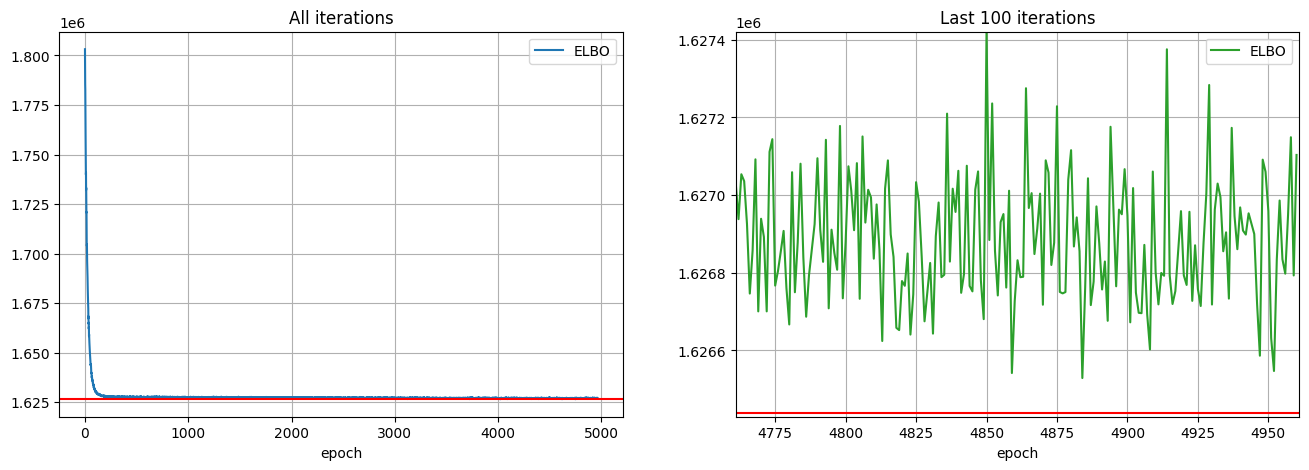

In [20]:
# Perform training using a decaying learning rate
num_steps = 5000
initial_lr = 0.03
final_lr = 0.005
gamma = final_lr / initial_lr
lrd = gamma ** (1 / num_steps)
adam = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd, 'betas': (0.80, 0.99)})

phase_fit.fit(optimizer=adam, num_steps=num_steps)

## Visualize manifold coordinates (phase) and geometry (gene harmonics) 

In [21]:
# Put estimations in new objects
cycle_pyro = phase_fit.cycle_pyro
phase_pyro = phase_fit.phase_pyro

In [22]:
fit_ElogS = phase_fit.posterior["ElogS"].squeeze().numpy() # raw counts
fit_ElogS2 = phase_fit.posterior["ElogS2"].squeeze().numpy() # size-normalized counts for cleaner visualization

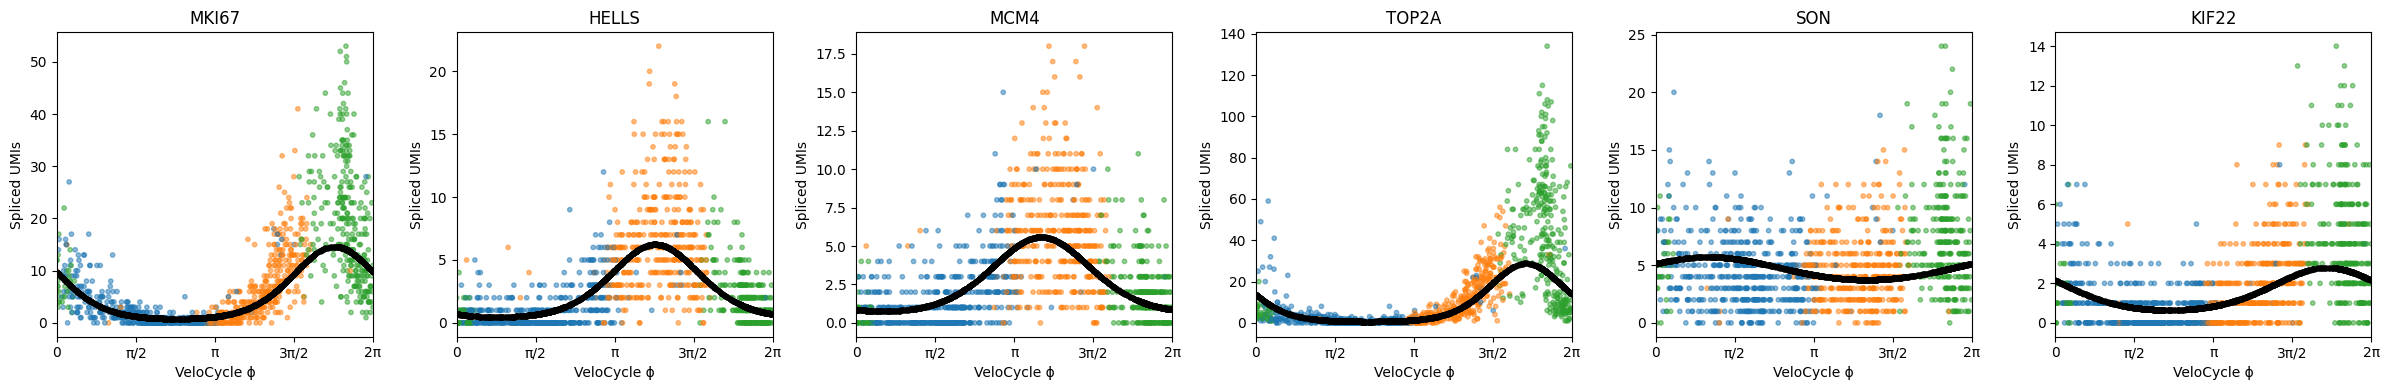

In [23]:
# Visualize the results for a subset of genes, colored by categorical cell cycle phase
name2color = {'G1':"tab:blue", 'S':"tab:orange", 'G2M':"tab:green"}
gene_list = ["MKI67", "HELLS", "MCM4", "TOP2A", "SON", "KIF22"]
gene_names = np.array(data_to_fit.var.index)
plt.figure(None,(24, 4))
ix = 1
for i in range(0, len(gene_list)):
    g = gene_list[i]
    plt.subplot(1, len(gene_list), ix)
    plt.scatter(phase_pyro.phis, 
                metapar.S[np.where(gene_names==g)[0][0], :].squeeze().cpu().numpy(), 
                s=10, alpha=0.5, c=[name2color[x] for x in data_to_fit.obs["phase"]])
    plt.scatter(phase_pyro.phis, 
                np.exp(fit_ElogS2[np.where(gene_names==g)[0][0], :]), 
                s=10, c="black")
    plt.title(g)
    plt.xlabel("VeloCycle ϕ")
    plt.ylabel("Spliced UMIs")
    plt.xlim(0, 2*np.pi)
    plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],["0", "π/2", "π", "3π/2", "2π"])
    ix+=1
plt.tight_layout()
plt.show()

In [24]:
# Examine the periodicity and geometry of fitted genes
xs = phase_fit.fourier_coef[1]
ys = phase_fit.fourier_coef[2]
r = np.log10( np.sqrt(xs**2+ys**2) / phase_fit.fourier_coef_sd[1:, :].sum(0) )
angle = np.arctan2(xs, ys)
angle = (angle)%(2*np.pi)

phis_df = pd.DataFrame([angle, r])
phis_df.columns = data_to_fit.var.index

cycle_data_frame = pd.concat([phase_fit.cycle_pyro.means, phase_fit.cycle_pyro.stds, phis_df]).T
cycle_data_frame.columns = ["nu0 mean", "nu1sin mean", "nu1cos mean", "nu0 std", "nu1sin std", "nu1cos std", "peak_phase", "amplitude"]
cycle_data_frame["is_seurat_marker"] = [True if i in list(utils.S_genes_human)+list(utils.G2M_genes_human) else False for i in cycle_data_frame.index]
cycle_data_frame.head()

,nu0 mean,nu1sin mean,nu1cos mean,nu0 std,nu1sin std,nu1cos std,peak_phase,amplitude,is_seurat_marker
AATF,0.111329,0.111525,-0.063305,0.029696,0.039639,0.033536,2.087074,0.243658,False
ABL1,0.112652,0.050265,-0.190403,0.030217,0.038512,0.040083,2.883486,0.398906,False
ACTB,5.403975,0.104787,-0.091198,0.007277,0.010137,0.009620,2.286965,0.847038,False
ACTL6A,0.718830,0.017770,0.009466,0.021101,0.032981,0.027574,1.081358,-0.478225,False
ACTR2,2.337414,0.126442,-0.019733,0.011505,0.015424,0.015072,1.725615,0.622869,False


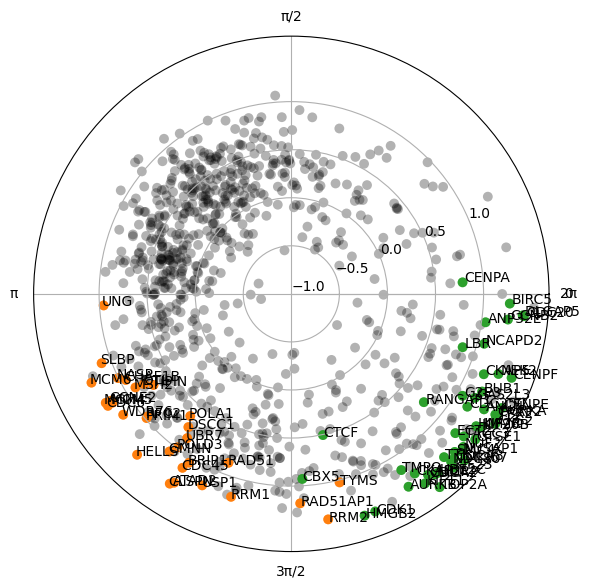

In [25]:
# View gene periodicity estimates with a polar plot
phase_fit.polar_plot()

## Run velocity-learning for a constant velocity

Later we will re-run this module to infer a non-constant (periodic) velocity

In [26]:
pyro.clear_param_store()

In [27]:
condition_design_matrix = copy.deepcopy(batch_design_matrix) # they are the same since there is only one sample

In [28]:
speed_prior = angularspeed.AngularSpeed.trivial_prior(condition_names=["fibroblasts"], harmonics=0)

In [29]:
# Condition the model on variables learned during manifold-learning
condition_on_dict = {"ϕxy":phase_pyro.phi_xy_tensor.T.to(device),
                     "ν": cycle_pyro.means_tensor.T.unsqueeze(-2).to(device),
                     "shape_inv": torch.tensor(phase_fit.disp_pyro).unsqueeze(-1).to(device)}

In [30]:
metaparameters_velocity = preprocessing.preprocess_for_velocity_estimation(data_to_fit, 
                                                             cycle_pyro, 
                                                             phase_pyro, 
                                                             speed_prior,
                                                             condition_design_matrix,
                                                             batch_design_matrix,
                                                             n_harmonics=1,
                                                             count_factor=metapar.count_factor,
                                                             ω_n_harmonics=0, 
                                                             device=device, 
                                                             condition_on=condition_on_dict,
                                                             with_delta_nu=False)

In [31]:
velocity_fit0 = velocity_inference_model.VelocityFitModel(metaparams=metaparameters_velocity, 
                                                         condition_on=condition_on_dict)

In [32]:
# velocity_fit0.check_model()
# velocity_fit0.check_guide()

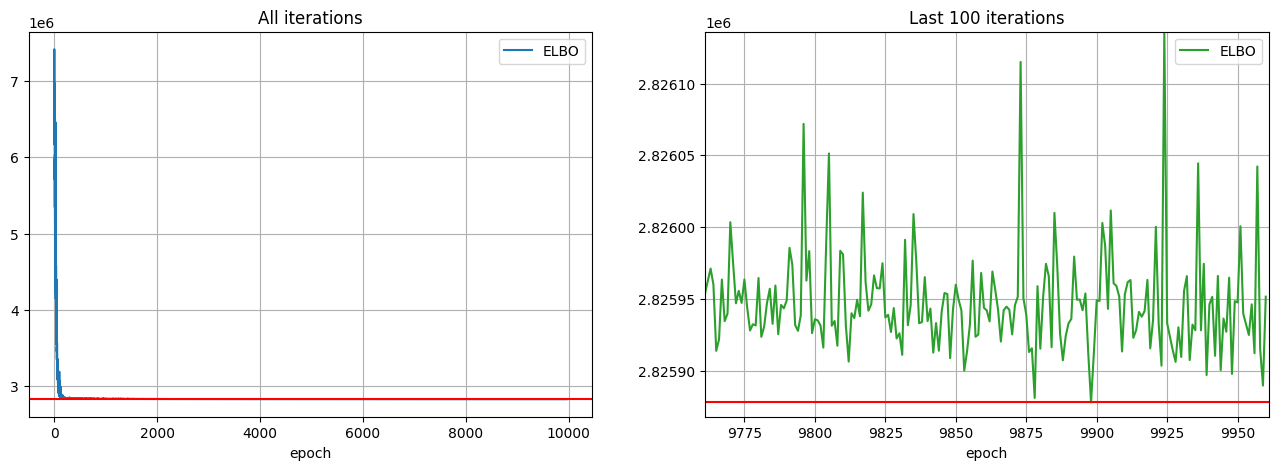

In [33]:
num_steps = 10000
initial_lr = 0.03
final_lr = 0.005
gamma = final_lr / initial_lr
lrd = gamma ** (1 / num_steps)
adam = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd, 'betas': (0.80, 0.99)})

velocity_fit0.fit(optimizer=adam, num_steps=num_steps)

In [34]:
# Put estimations in new objects
cycle_pyro = velocity_fit0.cycle_pyro
phase_pyro = velocity_fit0.phase_pyro
speed_pyro = velocity_fit0.speed_pyro

fit_ElogS = velocity_fit0.posterior["ElogS"].squeeze()
fit_ElogU = velocity_fit0.posterior["ElogU"].squeeze()

fit_ElogS2 = velocity_fit0.posterior["ElogS2"].squeeze()
fit_ElogU2 = velocity_fit0.posterior["ElogU2"].squeeze()

log_gammas = velocity_fit0.log_gammas
log_betas = velocity_fit0.log_betas

In [35]:
speed_pyro.means

,fibroblasts
nu0,0.435158


In [36]:
# Store entire posterior sampling into an object
full_pps_velo = velocity_fit0.posterior

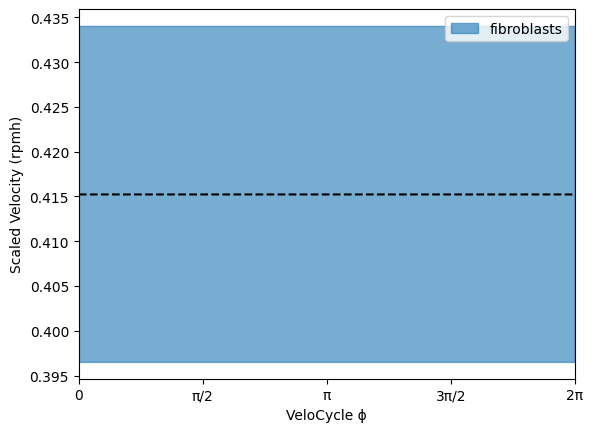

In [37]:
# Visualize the constant velocity estimate
omega = full_pps_velo["ω"].squeeze().numpy() / torch.exp(torch.mean(full_pps_velo["logγg"].squeeze().mean(0).detach())).numpy()
phi = phase_pyro.phis
omegas = []
phis = []
n2n = {"fibroblasts":0}
ids = np.array([n2n[i] for i in np.array(data_to_fit.obs["batch"])])
for i in range(len(data_to_fit.obs["batch"].unique())):
    omega1 = omega[:,np.where(ids == i)]
    phi1 = phi[np.where(ids == i)]
    omegas.append(omega1)
    phis.append(phi1)

labels = np.array(data_to_fit.obs["batch"].unique())

colors = ["tab:blue"]
for i in range(len(omegas)):
    plt.plot(phis[i][np.argsort(phis[i])], omegas[i].mean(0)[0][np.argsort(phis[i])], c="black", linestyle='dashed')
    
    tmp5 = np.percentile(omega[:, ids==i], 5, axis=0)
    tmp95 = np.percentile(omega[:, ids==i], 95, axis=0)
    phi_i = phi[ids==i] 
    plt.fill_between(x=phi_i[np.argsort(phi_i)],
                     y1=tmp5[np.argsort(phi_i)], 
                     y2=tmp95[np.argsort(phi_i)], 
                     alpha=0.6, color=colors[i], label = labels[i])

plt.xlabel("VeloCycle ϕ")
plt.ylabel("Scaled Velocity (rpmh)")
plt.xlim(0, 2*np.pi)
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],["0", "π/2", "π", "3π/2", "2π"])
plt.legend()
plt.show()

## Run the velocity-learning for a non-constant (periodic) velocity

In [38]:
pyro.clear_param_store()

In [39]:
condition_design_matrix = copy.deepcopy(batch_design_matrix)

In [40]:
speed_prior = angularspeed.AngularSpeed.trivial_prior(condition_names=["fibroblasts"], harmonics=1)

In [41]:
condition_on_dict = {"ϕxy":phase_pyro.phi_xy_tensor.T.to(device),
                     "ν": cycle_pyro.means_tensor.T.unsqueeze(-2).to(device),
                     "shape_inv": torch.tensor(phase_fit.disp_pyro).unsqueeze(-1).to(device)}

In [42]:
metaparameters_velocity = preprocessing.preprocess_for_velocity_estimation(data_to_fit, 
                                                             cycle_pyro, 
                                                             phase_pyro, 
                                                             speed_prior,
                                                             condition_design_matrix, 
                                                             batch_design_matrix, 
                                                             n_harmonics=1,
                                                             count_factor=metapar.count_factor,
                                                             ω_n_harmonics=1, 
                                                             device=device, 
                                                             condition_on=condition_on_dict,
                                                             with_delta_nu=False)

In [43]:
velocity_fit1 = velocity_inference_model.VelocityFitModel(metaparams=metaparameters_velocity, condition_on=condition_on_dict)

In [44]:
# velocity_fit1.check_model()
# velocity_fit1.check_guide()

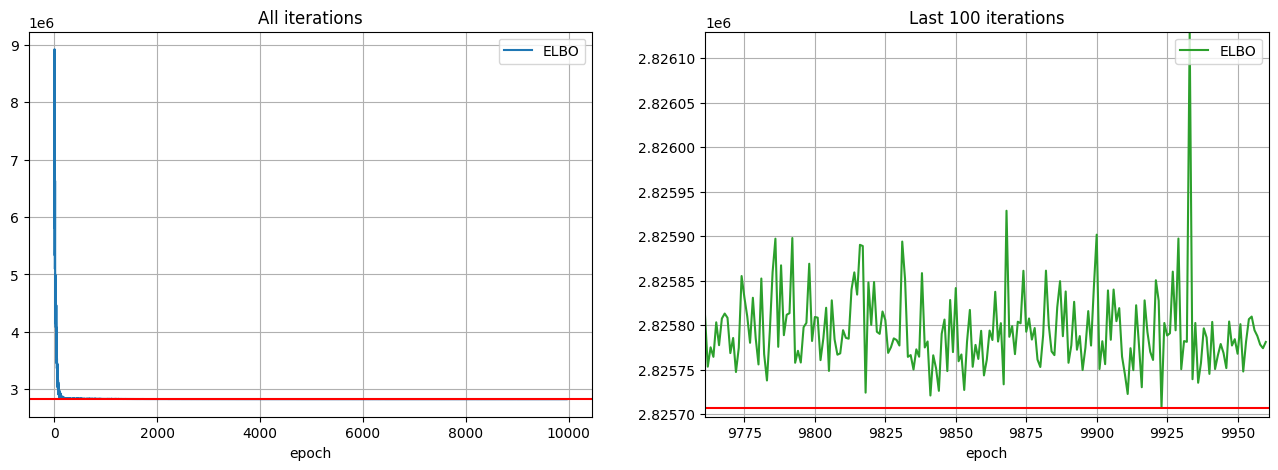

In [45]:
num_steps = 10000
initial_lr = 0.03
final_lr = 0.005
gamma = final_lr / initial_lr
lrd = gamma ** (1 / num_steps)
adam = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd, 'betas': (0.80, 0.99)})

velocity_fit1.fit(optimizer=adam, num_steps=num_steps)

In [46]:
# Put estimations in new objects
cycle_pyro = velocity_fit1.cycle_pyro
phase_pyro = velocity_fit1.phase_pyro
speed_pyro = velocity_fit1.speed_pyro

fit_ElogS = velocity_fit1.posterior["ElogS"].squeeze()
fit_ElogU = velocity_fit1.posterior["ElogU"].squeeze()

fit_ElogS2 = velocity_fit1.posterior["ElogS2"].squeeze()
fit_ElogU2 = velocity_fit1.posterior["ElogU2"].squeeze()

log_gammas = velocity_fit1.log_gammas
log_betas = velocity_fit1.log_betas

In [47]:
speed_pyro.means

,fibroblasts
nu0,0.413957
nu1_cos,-0.018423
nu1_sin,0.088191


In [48]:
# Store entire posterior sampling into an object
full_pps_velo = velocity_fit1.posterior

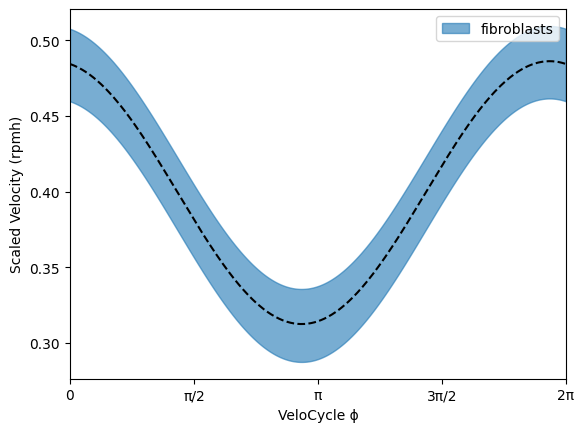

In [49]:
# Visualize the constant velocity estimate
omega = full_pps_velo["ω"].squeeze().numpy() / torch.exp(torch.mean(full_pps_velo["logγg"].squeeze().mean(0).detach())).numpy()
phi = phase_pyro.phis
omegas = []
phis = []
n2n = {"fibroblasts":0}
ids = np.array([n2n[i] for i in np.array(data_to_fit.obs["batch"])])
for i in range(len(data_to_fit.obs["batch"].unique())):
    omega1 = omega[:,np.where(ids == i)]
    phi1 = phi[np.where(ids == i)]
    omegas.append(omega1)
    phis.append(phi1)

labels = np.array(data_to_fit.obs["batch"].unique())

colors = ["tab:blue"]
for i in range(len(omegas)):
    plt.plot(phis[i][np.argsort(phis[i])], omegas[i].mean(0)[0][np.argsort(phis[i])], c="black", linestyle='dashed')
    
    tmp5 = np.percentile(omega[:, ids==i], 5, axis=0)
    tmp95 = np.percentile(omega[:, ids==i], 95, axis=0)
    phi_i = phi[ids==i] 
    plt.fill_between(x=phi_i[np.argsort(phi_i)],
                     y1=tmp5[np.argsort(phi_i)], 
                     y2=tmp95[np.argsort(phi_i)], 
                     alpha=0.6, color=colors[i], label = labels[i])

plt.xlabel("VeloCycle ϕ")
plt.ylabel("Scaled Velocity (rpmh)")
plt.xlim(0, 2*np.pi)
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],["0", "π/2", "π", "3π/2", "2π"])
plt.legend()
plt.show()

## Downstream analysis and visualizations

### (1) What is the cell cycle period in a real (hours) time scale?

In [50]:
# Measure cell cycle length in true time
# Constant velocity case
from scipy.integrate import trapz
period = []

mean_gamma  = np.exp(np.mean(velocity_fit0.log_gammas))
full_pps_velo = velocity_fit0.posterior
nu_omega = full_pps_velo["νω"].squeeze()/mean_gamma

grid_phi = torch.tensor(np.linspace(0, 2*np.pi, 20)).float()
omegas_on_grid = nu_omega.unsqueeze(-1) @ utils.torch_basis(grid_phi, kind="fourier", num_harmonics=0).T
period = trapz(1/omegas_on_grid, grid_phi)

0.5*(np.percentile(period, 95)-np.percentile(period, 5)), np.mean(period)

(0.6851256608963014, 15.143842)

In [51]:
# Non-constant (periodic) velocity case
period = []

mean_gamma  = np.exp(np.mean(velocity_fit1.log_gammas))
full_pps_velo = velocity_fit1.posterior
nu_omega = full_pps_velo["νω"].squeeze()/mean_gamma

grid_phi = torch.tensor(np.linspace(0, 2*np.pi, 20)).float()
omegas_on_grid = nu_omega @ utils.torch_basis(grid_phi, kind="fourier", num_harmonics=1).T
period = trapz(1/omegas_on_grid, grid_phi)

0.5*(np.percentile(period, 95)-np.percentile(period, 5)), np.mean(period)

(1.0296500444412224, 16.149128)

### (2) Are there differences in cell cycle speed between categorical cell cycle phases?

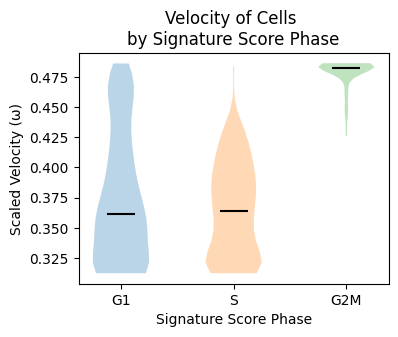

In [52]:
plt.figure(None, (4, 3))
omega = full_pps_velo["ω"].squeeze().numpy() / torch.exp(torch.mean(full_pps_velo["logγg"].squeeze().mean(0).detach())).numpy()
data1 = omega[:, data_to_fit.obs["phase"]=="G1"].mean(0)
data2 = omega[:, data_to_fit.obs["phase"]=="S"].mean(0)
data3 = omega[:, data_to_fit.obs["phase"]=="G2M"].mean(0)

# Combine the three data sets into a list
all_data = [data1, data2, data3]

# Create the violin plot
parts = plt.violinplot(all_data, showmedians=True, points=20, showextrema=False)

# Specify the colors you want to use
colors = ['tab:blue', 'tab:orange', 'tab:green']

# Loop to set the colors
for pc, color in zip(parts['bodies'], colors):
    pc.set_facecolor(color)

# Set the color for the mean line
for partname in ('cmedians',):
    part = parts[partname]
    part.set_edgecolor('black')
    part.set_linewidth(1.5)
    
# Customize ticks and labels
plt.xticks([1, 2, 3], ['G1', 'S', 'G2M'])

# Add title and axis labels
plt.title("Velocity of Cells \nby Signature Score Phase")
plt.xlabel("Signature Score Phase")
plt.ylabel("Scaled Velocity (ω)")
plt.show()

### (3) Do the velocity kinetic parameters and spliced-unspliced delays correlate with one another?

In [53]:
# Investigate changes to the shift along the cell cycle with non-zero harmonic. Should the shift change?
fit_ElogS2 = velocity_fit0.posterior["ElogS2"]
fit_ElogU2 = velocity_fit0.posterior["ElogU2"]
phis = velocity_fit0.phase_pyro.phis
shift_obs = pycircstat.cdiff(phis[np.argmax(fit_ElogS2.numpy().T, axis=0)], phis[np.argmax(fit_ElogU2.numpy().T, axis=0)])

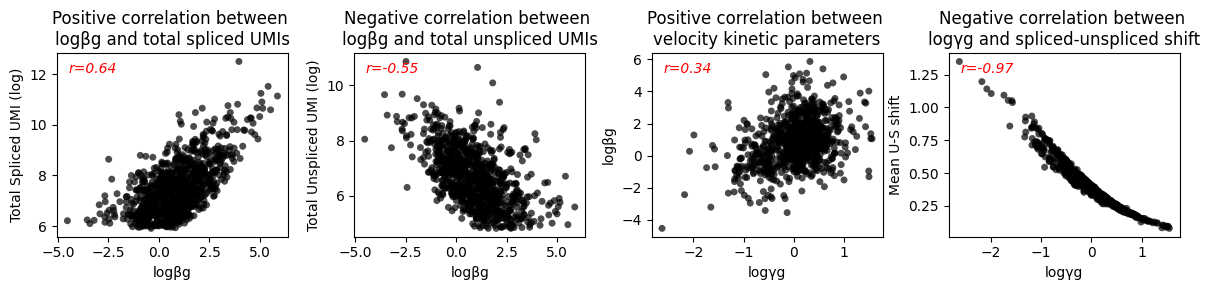

In [54]:
from scipy.stats import pearsonr

# Helper function to compute the Pearson correlation and add it as text to the plot
def add_pearson_corr_text(x, y, ax):
    corr, _ = pearsonr(x, y)
    ax.text(0.05, 0.95, f"r={corr:.2f}", color='red', ha='left', va='top', transform=ax.transAxes, style='italic')

# Initialize the figure
plt.figure(None, (12, 3))

# Splicing rate vs log spliced counts
ax1 = plt.subplot(1, 4, 1)
ax1.scatter(velocity_fit0.log_betas, np.log(data_to_fit.layers["spliced"].toarray().sum(0)), c='black', edgecolor='none', s=25, alpha=0.7, rasterized=True)
plt.xlabel("logβg")
plt.ylabel("Total Spliced UMI (log)")
plt.title("Positive correlation between \nlogβg and total spliced UMIs")
add_pearson_corr_text(velocity_fit1.log_betas, np.log(data_to_fit.layers["spliced"].toarray().sum(0)), ax1)

# Splicing rate vs log unspliced counts
ax2 = plt.subplot(1, 4, 2)
ax2.scatter(velocity_fit0.log_betas, np.log(data_to_fit.layers["unspliced"].toarray().sum(0)), c='black', edgecolor='none', s=25, alpha=0.7, rasterized=True)
plt.xlabel("logβg")
plt.ylabel("Total Unspliced UMI (log)")
plt.title("Negative correlation between \nlogβg and total unspliced UMIs")
add_pearson_corr_text(velocity_fit1.log_betas, np.log(data_to_fit.layers["unspliced"].toarray().sum(0)), ax2)

# Degradation rate vs splicing rate
ax3 = plt.subplot(1, 4, 3)
ax3.scatter(velocity_fit0.log_gammas, velocity_fit0.log_betas, edgecolor='none', s=25, c='black', alpha=0.7, rasterized=True)
plt.xlabel("logγg")
plt.ylabel("logβg")
plt.title("Positive correlation between \nvelocity kinetic parameters")
add_pearson_corr_text(velocity_fit1.log_gammas, velocity_fit1.log_betas, ax3)

# Degradation rate vs unspliced-spliced delay
ax4 = plt.subplot(1, 4, 4)
ax4.scatter(velocity_fit0.log_gammas, shift_obs, edgecolor='none', s=25, c='black', alpha=0.7, rasterized=True)
plt.xlabel("logγg")
plt.ylabel("Mean U-S shift")
plt.title("Negative correlation between \nlogγg and spliced-unspliced shift")
add_pearson_corr_text(velocity_fit1.log_gammas, shift_obs, ax4)

plt.tight_layout()
plt.show()

### (4) If we stratify by continuous cell cycle phase bins, do we see unspliced-spliced delays changing along the manifold?

In [55]:
# Stratify by phase of the cell cycle 
# and examine unspliced-spliced delay of genes peaking in those phases
cycle_data_frame["gene"] = cycle_data_frame.index
cycle_data_frame.set_index('gene', inplace=True)

# Define the number of bins
num_bins = 20
bin_width = 2 * np.pi / num_bins

# Calculate the bin index for each gene
cycle_data_frame['bin_index'] = ((cycle_data_frame['peak_phase'] + 2 * np.pi) % (2 * np.pi) / bin_width).astype(int)
cycle_data_frame["shift_obs"] = shift_obs

shifts_by_bin = []
shifts_by_bin_std = []
for i in range(0, num_bins):
    shifts_by_bin.append(np.mean(cycle_data_frame[cycle_data_frame['bin_index']==i]["shift_obs"]))
    shifts_by_bin_std.append(np.std(cycle_data_frame[cycle_data_frame['bin_index']==i]["shift_obs"]))
    
shifts_by_bin = np.array(shifts_by_bin)
shifts_by_bin_std = np.array(shifts_by_bin_std)

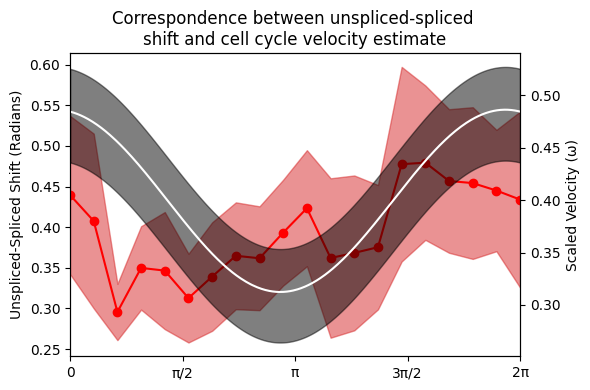

In [56]:
# Plot the line
# Create the first plot
fig, ax1 = plt.subplots(figsize=(6, 4))


ax1.plot(np.linspace(0, 2*np.pi, num_bins), shifts_by_bin, 'o-', label='Data', c='red')

# Plot the shaded region representing the standard deviation
ax1.fill_between(np.linspace(0, 2*np.pi, num_bins),
                 shifts_by_bin - shifts_by_bin_std / 2,
                 shifts_by_bin + shifts_by_bin_std / 2,
                 color='tab:red', alpha=0.5, label='Standard Deviation')
ax1.set_ylabel("Unspliced-Spliced Shift (Radians)")

full_pps_velo = velocity_fit1.posterior
omega = full_pps_velo["ω"].squeeze().numpy() / torch.exp(torch.mean(full_pps_velo["logγg"].squeeze().mean(0).detach())).numpy()
phi = velocity_fit1.phase_pyro.phis

# Create the second y-axis
ax2 = ax1.twinx()
sidx = np.argsort(phi)
ax2.plot(phi[sidx], omega.mean(0)[sidx], c='white')

tmp5 = np.percentile(omega[:, :], 0, axis=0)
tmp95 = np.percentile(omega[:, :], 100, axis=0)
ax2.fill_between(x=phi[sidx],
                 y1=tmp5[sidx], 
                 y2=tmp95[sidx], 
                 alpha=0.5, color="black")
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],["0", "π/2", "π", "3π/2", "2π"])
plt.xlim(0, 2*np.pi)
plt.xlabel("VeloCycle Phase (ϕ)")
ax2.set_ylabel("Scaled Velocity (ω)")
plt.title("Correspondence between unspliced-spliced \nshift and cell cycle velocity estimate")

plt.tight_layout()
plt.show()

## Save results as pickle objects

In [57]:
del phase_fit.metaparams
del phase_fit.metaparams_avg

del velocity_fit1.metaparams
del velocity_fit1.metaparams_avg

In [58]:
# Complete information
pickle.dump([phase_fit, velocity_fit1], open("capolupo_fibroblasts_velocycle_output.pkl", "wb"))

In [59]:
# Just the essentials
velocity_fit1.phase_pyro.save("capolupo_fibroblasts_phase.csv")
velocity_fit1.cycle_pyro.save("capolupo_fibroblasts_cycle.csv")
velocity_fit1.speed_pyro.save("capolupo_fibroblasts_speed.csv")